## XGBoost algorithm for MNIST dataset classification

In [6]:
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt

#load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 13s 1us/step


In [10]:
print(type(x_train))
print(x_train.shape)
print(type(x_test))
print(x_test.shape)

<class 'numpy.ndarray'>
(60000, 28, 28)
<class 'numpy.ndarray'>
(10000, 28, 28)


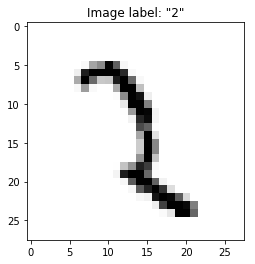

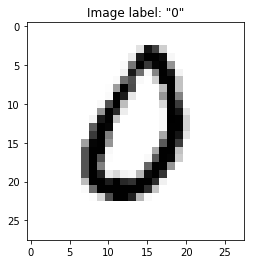

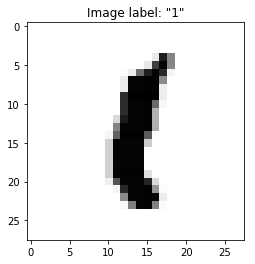

In [21]:
import matplotlib.pyplot as plt
for i in [444,666,7788]:
    image_index = i
    plt.imshow(x_train[image_index], cmap='Greys')
    plt.title("Image label: \"{}\"".format(y_train[image_index]))
    plt.show()